# SSD Evaluation Tutorial

This is a brief tutorial that explains how compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms. You can find details about these computation methods [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#sec:ap).

As an example we'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: I that in case you would like to evaluate a model on MS COCO, I would recommend to follow the [MS COCO evaluation notebook](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_evaluation_COCO.ipynb) instead, because it can produce the results format required by the MS COCO evaluation server and uses the official MS COCO evaluation code, which computes the mAP slightly differently from the Pascal VOC method.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results. The models that were trained on MS COCO and fine-tuned on Pascal VOC require the MS COCO scaling factors, not the Pascal VOC scaling factors.

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 512
img_width = 512
n_classes = 20
model_mode = 'inference'

In [3]:
K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.01,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)

# weights_path = 'VGG_VOC0712Plus_SSD_512x512_iter_240000.h5'
weights_path = 'final_weights.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.cast` instead.


In [4]:
K.clear_session()
model_path = 'final_model.h5'
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma



## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [4]:
dataset = DataGenerator()
# TODO: Set the paths to the dataset here.
Pascal_VOC_dataset_images_dir = './datasets/VOCdevkit/VOC2007/JPEGImages/'
Pascal_VOC_dataset_annotations_dir = './datasets/VOCdevkit/VOC2007/Annotations/'
Pascal_VOC_dataset_image_set_filename = './datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test.txt': 100%|██████████| 200/200 [00:04<00:00, 49.66it/s]


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [5]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 200

Producing predictions batch-wise:   0%|          | 0/25 [00:00<?, ?it/s]WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

Producing predictions batch-wise: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]
Matching predictions to ground truth, class 1/20.: 100%|██████████| 569/569 [00:00<00:00, 4315.11it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 183/183 [00:00<00:00, 3221.45it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 2783/2783 [00:00<00:00, 5192.47it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 2120/2120 [00:00<00:00, 4121.52it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 1763/1763 [00:00<00:00, 6500.47it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 192/1

## 4. Visualize the results

Let's take a look:

In [6]:
print('average_precisions =',average_precisions)

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

average_precisions = [0.0, 0.8181818181818182, 0.7528225963980154, 0.9188661980668736, 0.6890847497725947, 0.469775260200792, 1.0, 0.9583678009051142, 0.9579831932773111, 0.5946443614991018, 0.6728785777329466, 0.640458152958153, 0.9063852813852814, 0.9943181818181818, 0.7406123086535459, 0.7724157347947395, 0.5865781619201592, 0.778827233372688, 0.6022727272727273, 0.8065876152832675, 0.8181818181818182]
aeroplane     AP    0.818
bicycle       AP    0.753
bird          AP    0.919
boat          AP    0.689
bottle        AP    0.47
bus           AP    1.0
car           AP    0.958
cat           AP    0.958
chair         AP    0.595
cow           AP    0.673
diningtable   AP    0.64
dog           AP    0.906
horse         AP    0.994
motorbike     AP    0.741
person        AP    0.772
pottedplant   AP    0.587
sheep         AP    0.779
sofa          AP    0.602
train         AP    0.807
tvmonitor     AP    0.818

              mAP   0.774


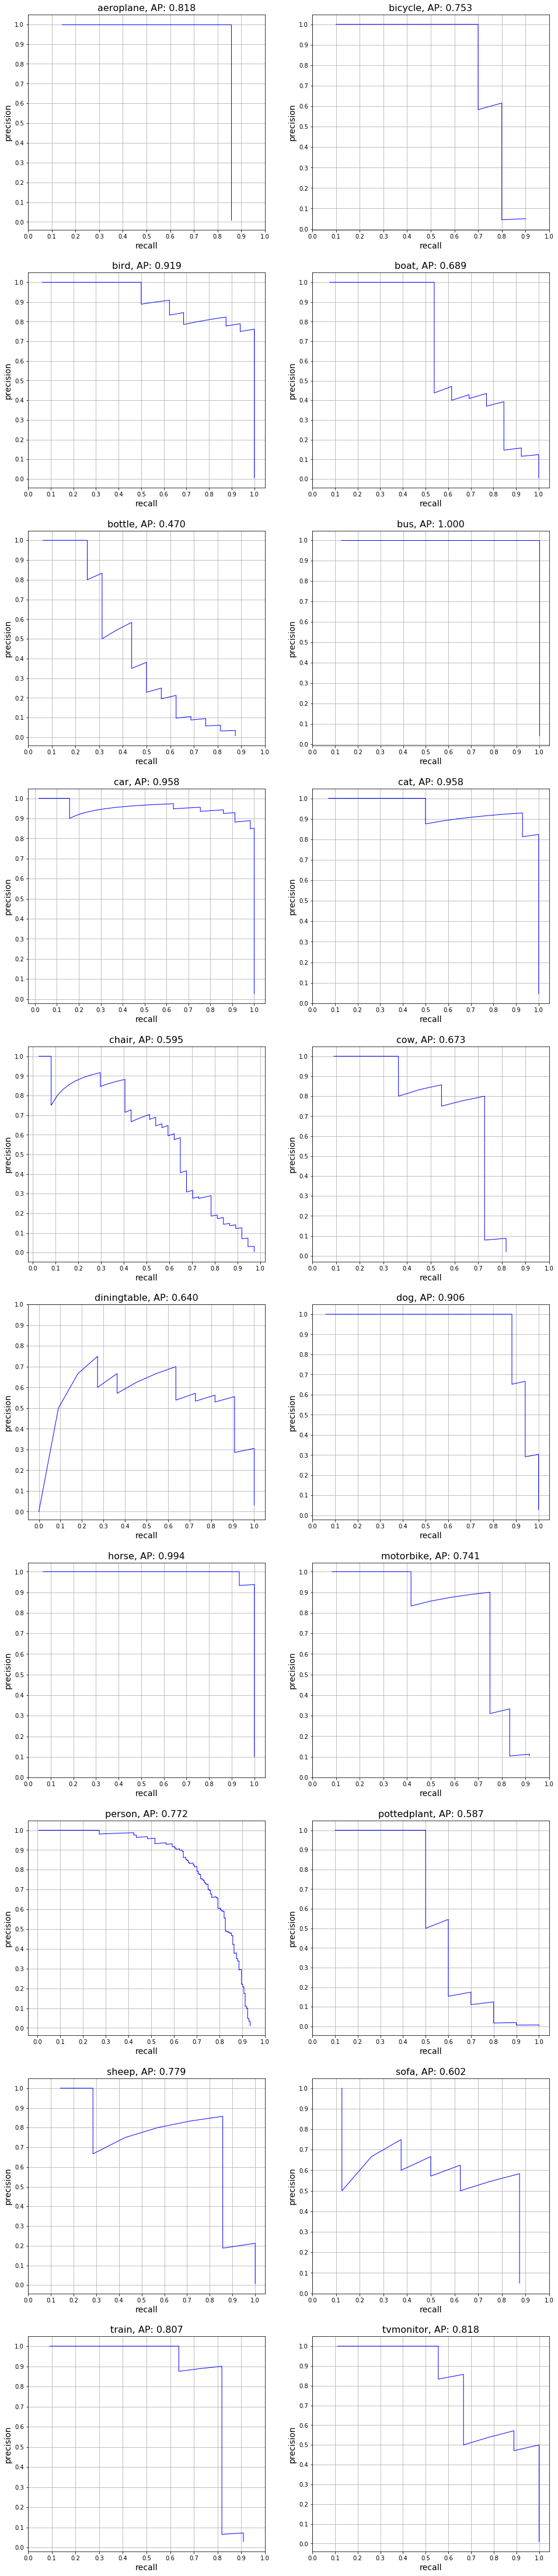

In [7]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [9]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 1/20.: 100%|██████████| 569/569 [00:00<00:00, 3742.55it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 183/183 [00:00<00:00, 3208.05it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 2783/2783 [00:00<00:00, 3477.73it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 2120/2120 [00:00<00:00, 4618.46it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 1763/1763 [00:00<00:00, 7585.06it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 192/192 [00:00<00:00, 5604.04it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 2187/2187 [00:00<00:00, 4789.36it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 302/302 [00:00<00:00, 2821.74it/s]
Matching predictions to ground truth, class 9/20.: 100%|██████████| 8388/8388 [00:01<00:00, 8040.77it/s]
Matching predictions to ground truth, class 10/20.: 100%|██████

In [10]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.714
bicycle       AP    0.762
bird          AP    0.87
boat          AP    0.684
bottle        AP    0.444
bus           AP    0.875
car           AP    0.947
cat           AP    0.898
chair         AP    0.604
cow           AP    0.665
diningtable   AP    0.681
dog           AP    0.922
horse         AP    0.933
motorbike     AP    0.744
person        AP    0.796
pottedplant   AP    0.587
sheep         AP    0.776
sofa          AP    0.542
train         AP    0.8
tvmonitor     AP    0.778

              mAP   0.751
